In [3]:
import argparse

import numpy as np
import autograd.numpy as npa

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, fdfd_ez_nl, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.utils import imarr, get_value
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

## Operators for device parameterization

In [4]:
def operator_proj(rho, eta=0.5, beta=100):
    """Density projection
    """
    return npa.divide(npa.tanh(beta * eta) + npa.tanh(beta * (rho - eta)), 
                        npa.tanh(beta * eta) + npa.tanh(beta * (1 - eta)))

def operator_blur(rho, radius=2):
    """Blur operator implemented via two-dimensional convolution
    """
    rr, cc = circle(radius, radius, radius+1)
    kernel = np.zeros((2*radius+1, 2*radius+1), dtype=np.float)
    kernel[rr, cc] = 1
    kernel=kernel/kernel.sum()
    # For whatever reason HIPS autograd doesn't support 'same' mode, so we need to manually crop the output
    return conv(rho, kernel, mode='full')[radius:-radius,radius:-radius]

### Visualization of the projection

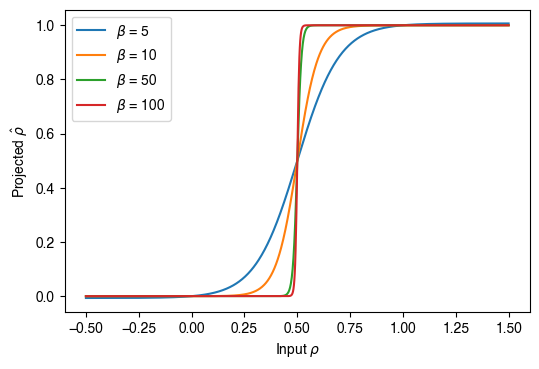

In [5]:
rho = np.linspace(-0.5, +1.5, 999)

plt.figure()
for beta in [5, 10, 50, 100]:
    plt.plot(rho, operator_proj(rho, beta=beta), label=r"$\beta$ = %d" % beta)

plt.xlabel(r"Input $\rho$")
plt.ylabel(r"Projected $\hat{\rho}$")
plt.legend()

### Visualization of the blur

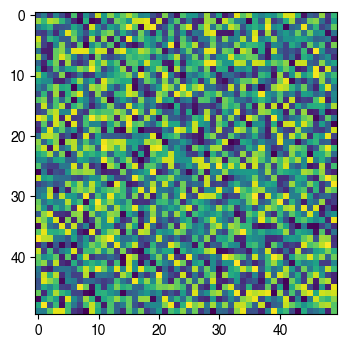

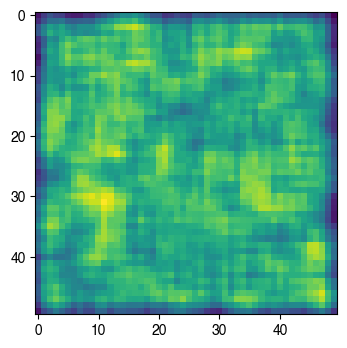

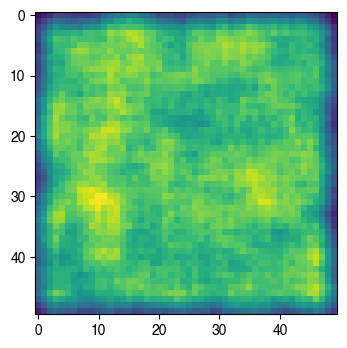

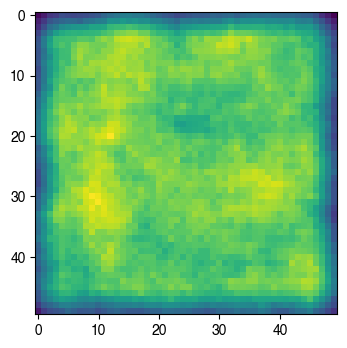

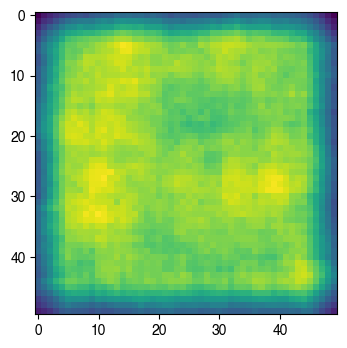

In [6]:
rho = np.random.rand(50, 50)

for radius in [None, 2, 3, 4, 5]:
    plt.figure()
    rho_p = operator_blur(rho, radius=radius) if radius is not None else rho
    plt.imshow(rho_p)

In [7]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    rho[0:int(Npml+space),int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    # Output waveguide 
    rho[int(Nx-Npml-space)::,int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    # Output probe slice
    output_slice = (Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice))))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 0.5

    # Need to break the symmetry so that the gradient is not zero!
#     rho = rho + 0*np.random.rand(Nx, Ny)*design_region

    return rho, design_region, input_slice, output_slice

def make_rho(rho, design_region, radius=2):
    """Helper function for applying the blue to only the design region
    """
    lpf_rho = operator_blur(rho, radius=radius) * design_region
    bg_rho = rho * (design_region==0).astype(np.float)
    return bg_rho + lpf_rho

def viz_sim(epsr):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    ax[0].plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
    ax[0].plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    plt.show()
    return (simulation, ax)

In [8]:
# Number of epochs in the optimization 
Nsteps=30
# Step size for the Adam optimizer
step_size=1e-2
# Angular frequency of the source in 1/s
omega=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=120
# Number of pixels in y-direction
Ny=120
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
blur_radius=5
# Strength of the binarizing projection
beta=100.0
# Middle point of the binarizing projection
eta=0.5
# Space between the PMLs and the design region (in pixels)
space=default=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8

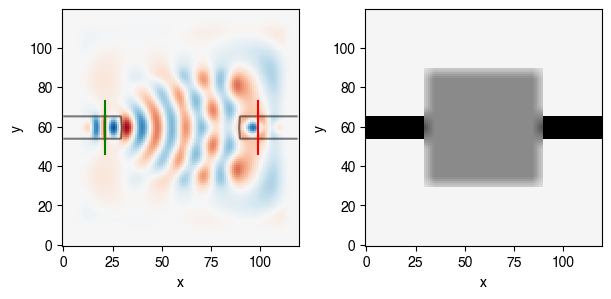

Epoch:   1/ 30 | Duration: 0.17 secs | Value: 1.136794e-13
Epoch:   2/ 30 | Duration: 0.17 secs | Value: 5.558919e-07
Epoch:   3/ 30 | Duration: 0.17 secs | Value: 1.123435e-06
Epoch:   4/ 30 | Duration: 0.18 secs | Value: 1.270020e-06
Epoch:   5/ 30 | Duration: 0.17 secs | Value: 1.903927e-06
Epoch:   6/ 30 | Duration: 0.18 secs | Value: 2.104258e-06
Epoch:   7/ 30 | Duration: 0.18 secs | Value: 2.079788e-06
Epoch:   8/ 30 | Duration: 0.17 secs | Value: 1.920077e-06
Epoch:   9/ 30 | Duration: 0.17 secs | Value: 1.952441e-06
Epoch:  10/ 30 | Duration: 0.18 secs | Value: 2.123239e-06
Epoch:  11/ 30 | Duration: 0.18 secs | Value: 2.263395e-06
Epoch:  12/ 30 | Duration: 0.18 secs | Value: 2.334453e-06
Epoch:  13/ 30 | Duration: 0.17 secs | Value: 2.352569e-06
Epoch:  14/ 30 | Duration: 0.17 secs | Value: 2.356184e-06
Epoch:  15/ 30 | Duration: 0.17 secs | Value: 2.376637e-06
Epoch:  16/ 30 | Duration: 0.17 secs | Value: 2.409881e-06
Epoch:  17/ 30 | Duration: 0.18 secs | Value: 2.439074e-

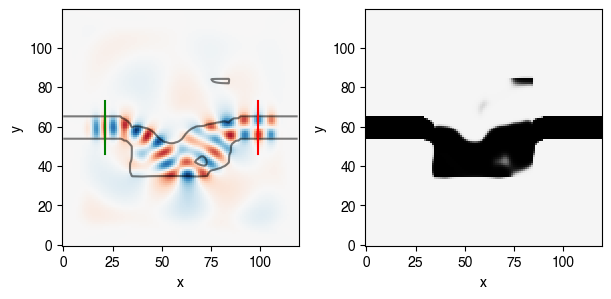

In [9]:
# Setup initial structure
rho_init, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)
epsr = epsr_min + (epsr_max-epsr_min) * make_rho(rho_init, design_region, radius=blur_radius)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr)

# Define optimization objective
def measure_modes(Ez):
    return npa.abs(npa.sum(npa.conj(Ez)*probe))

def objective(rho):
    rho = rho.reshape((Nx, Ny))
    _rho = make_rho(rho, design_region, radius=blur_radius)
    epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(_rho, beta=beta, eta=eta)
    simulation.eps_r = epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez)

# Run optimization
objective_jac = jacobian(objective, mode='reverse')
(rho_optimum, loss) = adam_optimize(objective, rho_init.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', 
                         mask=design_region.flatten(), step_size=step_size)
rho_optimum = rho_optimum.reshape((Nx, Ny))

# Simulate optimal device
epsr = epsr_min + (epsr_max-epsr_min)*operator_proj(make_rho(rho_optimum, 
                        design_region, radius=blur_radius), beta=beta, eta=eta)
simulation, ax = viz_sim(epsr)